## Introduction

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression #We will be building a linear regression model
from sklearn.metrics import mean_squared_error #We will use RMSE as the error metric
from sklearn.model_selection import cross_val_score, KFold #We will use K-Fold cross validation as the validation technique

In [65]:
#Reading in the data
df = pd.read_csv('AmesHousing.tsv',delimiter='\t')
df.head(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Creating functions to help with iteration later

In [67]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    #Splitting training and test set
    train = df[0:1460]
    test = df[1460:]
    
    #Training a linear regression model
    lr = LinearRegression()
    numeric_train = train.select_dtypes(include='number')
    numeric_test = test.select_dtypes(include='number')
    #Removing the target column from the feature columns list
    features = numeric_train.columns.drop('SalePrice')
    lr.fit(numeric_train[features],numeric_train['SalePrice'])
    
    #Testing the model on the test set
    predictions = lr.predict(numeric_test[features])
    #Error checks
    mse = mean_squared_error(numeric_test['SalePrice'],predictions)
    rmse = np.sqrt(mse)
    return rmse
    
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

57088.25161263909

## Feature Engineering

Let us do the following to handle missing values:

1) All columns: Drop any columns where there are more than 5% missing values for now <br>
2) Text columns: Drop any with 1 or more missing values for now <br>
3) Numerical columns: Fill in with most common value in that column <br>

1) All columns: Drop any columns where there are more than 5% missing values for now <br>

In [44]:
#Identifying columns with more than 5% missing values
missing_counts = df.isnull().sum()
drop_missing_cols = missing_counts[df.isnull().sum() > len(df)*0.05].index
drop_missing_cols

#Drop these columns
df = df.drop(drop_missing_cols,axis=1)

2) Text columns: Drop any with 1 or more missing values for now <br>

In [45]:
#Identifying text columns with missing values
missing_counts_text = df.select_dtypes(include=['object']).isnull().sum()
drop_missing_cols_text = missing_counts_text[missing_counts_text > 0].index

#Drop these columns
df = df.drop(drop_missing_cols_text,axis=1)

3) Numerical columns: Fill in with most common value in that column 

In [50]:
#Identifying numeric columns with missing values
num_missing = df.select_dtypes(include='number').isnull().sum()
fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
fixable_numeric_cols

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [53]:
#Creating a dictionary with replacement values (modes) for each column above

replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Mas Vnr Area': 0.0}

In [54]:
#Replacing missing values using dictionary above

df = df.fillna(replacement_values_dict)

In [59]:
#Verifying that there are no more columns with missing values
df.isnull().sum().value_counts()

0    64
dtype: int64

In [60]:
#Creating new features that better capture the information in some of the features

years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [61]:
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [62]:
#Create new columns
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

#Drop rows with negative values for both of these new features
df = df.drop([1702, 2180, 2181], axis=0)

#No longer need original year columns
df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)

In [63]:
#Let us drop columns that aren't useful for ML
df = df.drop(["PID", "Order"], axis=1)

# Drop columns that leak info about the final sale
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

**Now let us update the transform_features( ) function below**

In [70]:
def transform_features(df):
    #Identifying columns with more than 5% missing values
    missing_counts = df.isnull().sum()
    drop_missing_cols = missing_counts[df.isnull().sum() > len(df)*0.05].index
    #Drop these columns
    df = df.drop(drop_missing_cols,axis=1)

    #Identifying text columns with missing values
    missing_counts_text = df.select_dtypes(include=['object']).isnull().sum()
    drop_missing_cols_text = missing_counts_text[missing_counts_text > 0].index
    #Drop these columns
    df = df.drop(drop_missing_cols_text,axis=1)
    
    #Identifying numeric columns with missing values
    num_missing = df.select_dtypes(include='number').isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    #Creating a dictionary with replacement values (modes) for each column above
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    #Replacing missing values using dictionary above
    df = df.fillna(replacement_values_dict)
    
    #Creating new features that better capture the information in some of the features
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    #Create new columns
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    #Drop rows with negative values for both of these new features
    df = df.drop([1702, 2180, 2181], axis=0)
    #No longer need original year columns
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    #Let us drop columns that aren't useful for ML
    df = df.drop(["PID", "Order"], axis=1)

    # Drop columns that leak info about the final sale
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    
    return df

    
def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    #Splitting training and test set
    train = df[0:1460]
    test = df[1460:]
    
    #Training a linear regression model
    lr = LinearRegression()
    numeric_train = train.select_dtypes(include='number')
    numeric_test = test.select_dtypes(include='number')
    #Removing the target column from the feature columns list
    features = numeric_train.columns.drop('SalePrice')
    lr.fit(numeric_train[features],numeric_train['SalePrice'])
    
    #Testing the model on the test set
    predictions = lr.predict(numeric_test[features])
    #Error checks
    mse = mean_squared_error(numeric_test['SalePrice'],predictions)
    rmse = np.sqrt(mse)
    return rmse
    
df = pd.read_csv('AmesHousing.tsv',delimiter='\t')
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

55275.367312413066

## Feature Selection

**Correlation** between columns and with the target column specifically

In [99]:
num_df = transform_df.select_dtypes(include='number')
abs_cor_mat = num_df.corr().abs()

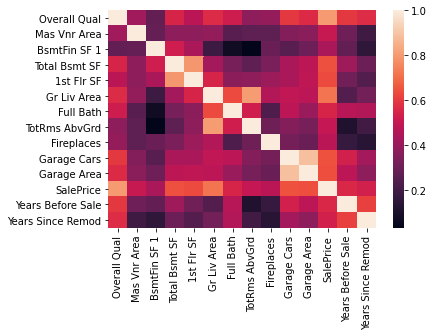

In [100]:
#Let us create a correlation heatmap base on the matrix above

sns.heatmap(abs_cor_mat)

In [101]:
#Correlation of each column with SalePrice
abs_corr_coeffs = abs_cor_mat['SalePrice'].sort_values(ascending=False)
abs_corr_coeffs

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Name: SalePrice, dtype: float64

In [102]:
#For now, let us use a threshold of 0.4 for correlation. Can iterate later as needed.

transform_df = transform_df.drop(abs_corr_coeffs [abs_corr_coeffs < 0.4].index,axis=1)

**Categorical Columns**

In [103]:
#List of column names from documentation that are supposed to be categorical

nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [108]:
#Categorical columns that are still in our dataset 
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

In [109]:
transform_cat_cols

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

In [111]:
#Number of unique values in each categorical column
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
uniqueness_counts

Street           2
Central Air      2
Land Contour     4
Lot Config       5
Bldg Type        5
Roof Style       6
Foundation       6
Heating          6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [113]:
#Drop columns with more than 10 unique values. Can iterate on this later if need.

tranform_df = transform_df.drop(uniqueness_counts[uniqueness_counts > 10].index,axis=1)

In [114]:
#Convert the text columns remaining into categorical column types
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
#Create dummy columns and add back to dataframe. Drop original text columns
transform_df = pd.concat([
    transform_df, 
    pd.get_dummies(transform_df.select_dtypes(include=['category']))
], axis=1).drop(text_cols,axis=1)

**Now let us update the select_features ( ) function below**

In [115]:
def transform_features(df):
    #Identifying columns with more than 5% missing values
    missing_counts = df.isnull().sum()
    drop_missing_cols = missing_counts[df.isnull().sum() > len(df)*0.05].index
    #Drop these columns
    df = df.drop(drop_missing_cols,axis=1)

    #Identifying text columns with missing values
    missing_counts_text = df.select_dtypes(include=['object']).isnull().sum()
    drop_missing_cols_text = missing_counts_text[missing_counts_text > 0].index
    #Drop these columns
    df = df.drop(drop_missing_cols_text,axis=1)
    
    #Identifying numeric columns with missing values
    num_missing = df.select_dtypes(include='number').isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    #Creating a dictionary with replacement values (modes) for each column above
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    #Replacing missing values using dictionary above
    df = df.fillna(replacement_values_dict)
    
    #Creating new features that better capture the information in some of the features
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    #Create new columns
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    #Drop rows with negative values for both of these new features
    df = df.drop([1702, 2180, 2181], axis=0)
    #No longer need original year columns
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    #Let us drop columns that aren't useful for ML
    df = df.drop(["PID", "Order"], axis=1)

    # Drop columns that leak info about the final sale
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    
    return df

    
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df


def train_and_test(df):
    #Splitting training and test set
    train = df[0:1460]
    test = df[1460:]
    
    #Training a linear regression model
    lr = LinearRegression()
    numeric_train = train.select_dtypes(include='number')
    numeric_test = test.select_dtypes(include='number')
    #Removing the target column from the feature columns list
    features = numeric_train.columns.drop('SalePrice')
    lr.fit(numeric_train[features],numeric_train['SalePrice'])
    
    #Testing the model on the test set
    predictions = lr.predict(numeric_test[features])
    #Error checks
    mse = mean_squared_error(numeric_test['SalePrice'],predictions)
    rmse = np.sqrt(mse)
    return rmse
    
df = pd.read_csv('AmesHousing.tsv',delimiter='\t')
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

33367.287183403896

## K-Fold Cross Validation

Lastly, let us iterate on the train_and_test function to implement **k-fold cross validation**

In [132]:
def train_and_test(df,k=0):
    lr = LinearRegression()
    if k==0:
        #Train/Test Validation 
        train = df[0:1460]
        test = df[1460:]
        features = train.columns.drop('SalePrice')
        #Training
        lr.fit(train[features],train['SalePrice'])
        #Predicting
        predictions = lr.predict(test[features])
        #Error Checks
        mse = mean_squared_error(test['SalePrice'],predictions)
        rmse = np.sqrt(mse)
        return rmse
    
    if k>0:
        kf = KFold(k,shuffle=True, random_state=1)
        features = df.columns.drop('SalePrice')
        mses = cross_val_score(lr,df[features],df['SalePrice'],scoring='neg_mean_squared_error', cv=kf)
        avg_rmse = np.mean(abs(mses)**0.5)
        return avg_rmse

Now let us bake this into our overall functions pipeline

In [162]:
def transform_features(df):
    #Identifying columns with more than 5% missing values
    missing_counts = df.isnull().sum()
    drop_missing_cols = missing_counts[df.isnull().sum() > len(df)*0.05].index
    #Drop these columns
    df = df.drop(drop_missing_cols,axis=1)

    #Identifying text columns with missing values
    missing_counts_text = df.select_dtypes(include=['object']).isnull().sum()
    drop_missing_cols_text = missing_counts_text[missing_counts_text > 0].index
    #Drop these columns
    df = df.drop(drop_missing_cols_text,axis=1)
    
    #Identifying numeric columns with missing values
    num_missing = df.select_dtypes(include='number').isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    #Creating a dictionary with replacement values (modes) for each column above
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    #Replacing missing values using dictionary above
    df = df.fillna(replacement_values_dict)
    
    #Creating new features that better capture the information in some of the features
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    #Create new columns
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    #Drop rows with negative values for both of these new features
    df = df.drop([1702, 2180, 2181], axis=0)
    #No longer need original year columns
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    #Let us drop columns that aren't useful for ML
    df = df.drop(["PID", "Order"], axis=1)

    # Drop columns that leak info about the final sale
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    
    return df

    
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df


def train_and_test(df,k=0):
    lr = LinearRegression()
    if k==0:
        #Train/Test Validation 
        train = df[0:1460]
        test = df[1460:]
        features = train.columns.drop('SalePrice')
        #Training
        lr.fit(train[features],train['SalePrice'])
        #Predicting
        predictions = lr.predict(test[features])
        #Error Checks
        mse = mean_squared_error(test['SalePrice'],predictions)
        rmse = np.sqrt(mse)
        return rmse

    elif k==1:
        #Simple Cross Validation
        np.random.seed(1)
        df = df.iloc[np.random.permutation(len(df))]
        fold_one = df[:1460]
        fold_two = df[1460:]
        features = fold_one.columns.drop('SalePrice')
        #Train on fold_one
        lr.fit(fold_one[features],fold_one['SalePrice'])
        predictions = lr.predict(fold_two[features])
        mse_one = mean_squared_error(fold_two['SalePrice'],predictions)
        rmse_one = np.sqrt(mse_one)
        #Train on fold_two
        lr.fit(fold_two[features],fold_two['SalePrice'])
        predictions = lr.predict(fold_one[features])
        mse_two = mean_squared_error(fold_one['SalePrice'],predictions)
        rmse_two = np.sqrt(mse_two)
        #Average RMSEs
        return np.mean([rmse_one,rmse_two])
        
    
    else:
        #K-Fold Cross Validation
        kf = KFold(k,shuffle=True, random_state=1)
        features = df.columns.drop('SalePrice')
        mses = cross_val_score(lr,df[features],df['SalePrice'],scoring='neg_mean_squared_error', cv=kf)
        avg_rmse = np.mean(abs(mses)**0.5)
        return avg_rmse


df = pd.read_csv('AmesHousing.tsv',delimiter='\t')
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df,k=10)
rmse

28361.902838900154